## Load documents with IDs

In [9]:
import requests
import pandas as pd

url_prefix = 'https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/03-evaluation/'
docs_url = url_prefix + 'search_evaluation/documents-with-ids.json'
documents = requests.get(docs_url).json()

ground_truth_url = url_prefix + 'search_evaluation/ground-truth-data.csv'
df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [10]:
ground_truth_url

'https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/03-evaluation/search_evaluation/ground-truth-data.csv'

In [11]:
documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ea739c65'}

In [12]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [13]:
doc_idx = {d['id']: d for d in documents}
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

## Index data

We'll generate embeddings using [the sentence transformers](https://sbert.net/) library, if you don't have it, install it with pip:

```bash
pip install sentence-transformers
```

This is a different way of turning sentences into vectors

In [77]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

In [78]:
from tqdm.auto import tqdm

In [ ]:
vectors = []

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    vector = model.encode(question + ' ' + text)
    vectors.append(vector)

100%|██████████| 948/948 [00:46<00:00, 20.32it/s]


In [16]:
import numpy as np

vectors = np.array(vectors)

In [18]:
#%pip install -U minsearch

In [79]:
import minsearch
import importlib.metadata

print(importlib.metadata.version("minsearch"))


0.0.4


In [20]:
from minsearch import VectorSearch

vindex = VectorSearch(keyword_fields=['course'])
vindex.fit(vectors, documents)

## Retrieval

In [80]:
def minsearch_vector_search(vector, course):
    return vindex.search(
        vector,
        filter_dict={'course': course},
        num_results=5
    )

def question_text_vector(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return minsearch_vector_search(v_q, course)

In [22]:
question_text_vector(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

[{'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'section': 'General course-related questions',
  'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'id': '5170565b'},
 {'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'section': 'General course-related questions',
  'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'id': '39fda9f0'},
 {'text': "Problem description\nThe accuracy and the loss are both still the same or nearly the same while training.\nSol

## The RAG flow

In [23]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [81]:
from openai import OpenAI

import os
from dotenv import load_dotenv
load_dotenv(os.path.abspath("/workspaces/llm-zoomcamp/.env"))

client = OpenAI(api_key = os.getenv("OPENAI_API_KEY"))

In [82]:
def llm(prompt, model='gpt-5'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [83]:
# previously: rag(query: str) -> str
def rag(query: dict, model='gpt-5') -> str:
    search_results = question_text_vector(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [27]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [28]:
rag(ground_truth[10])

'Yes. Everything is recorded. Course videos are pre‑recorded, and office hours live sessions are recorded too and available in the YouTube course playlist. You can also submit questions for office hours in advance and ask questions in Slack.'

In [29]:
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

## Cosine similarity metric

In [30]:
answer_orig = 'Yes, sessions are recorded if you miss one. Everything is recorded, allowing you to catch up on any missed content. Additionally, you can ask questions in advance for office hours and have them addressed during the live stream. You can also ask questions in Slack.'
answer_llm = 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

v_llm.dot(v_orig)

np.float32(0.75911725)

In [31]:
ground_truth[0]

{'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp',
 'document': '0227b872'}

In [32]:
len(ground_truth)

1830

In [34]:
answers = {}

In [ ]:
# for i, rec in enumerate(tqdm(ground_truth)):
#     if i in answers:
#         continue

#     answer_llm = rag(rec)
#     doc_id = rec['document']
#     original_doc = doc_idx[doc_id]
#     answer_orig = original_doc['text']

#     answers[i] = {
#         'answer_llm': answer_llm,
#         'answer_orig': answer_orig,
#         'document': doc_id,
#         'question': rec['question'],
#         'course': rec['course'],
#     }

  0%|          | 0/1830 [00:00<?, ?it/s]

In [107]:
results_gpt4o = [None] * len(ground_truth)

for i, val in answers.items():
    results_gpt4o[i] = val.copy()
    results_gpt4o[i].update(ground_truth[i])

In [95]:
import pandas as pd

In [110]:
df_gpt4o = pd.DataFrame(results_gpt4o)

In [112]:
!mkdir data

In [113]:
df_gpt4o.to_csv('data/results-gpt4o.csv', index=False)

## Evaluating GPT 3.5

In [119]:
rag(ground_truth[10], model='gpt-3.5-turbo')

"No, sessions are recorded so if you miss one, you won't miss anything."

In [120]:
from tqdm.auto import tqdm

from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=6)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [121]:
def process_record(rec):
    model = 'gpt-3.5-turbo'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [122]:
process_record(ground_truth[10])

{'answer_llm': 'Yes, sessions are recorded if you miss one. Everything is recorded, so you won’t miss anything, and you can also ask questions for office hours in advance which will be covered during the live stream. You can always ask questions in Slack as well.',
 'answer_orig': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

In [123]:
results_gpt35 = map_progress(pool, ground_truth, process_record)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [124]:
df_gpt35 = pd.DataFrame(results_gpt35)
df_gpt35.to_csv('data/results-gpt35.csv', index=False)

In [125]:
!head data/results-gpt35.csv

answer_llm,answer_orig,document,question,course
You can sign up for the course by going to the course page at http://mlzoomcamp.com/ and scrolling down to access the course materials.,"Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:
Data Engineering Zoomcamp FAQ
In the course GitHub repository thereâ€™s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo
work",0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
"I am sorry, but there is no direct link provided in the FAQ database for signing up for the course. However, you can find a link in the course GitHub repository at this address: https://airtable.com/shryxwLd0COOEaqXo.","Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did thi

## Cosine similarity

A->Q->A' cosine similarity

A -> Q -> A'

cosine(A, A')

### gpt-4o

In [64]:
import pandas as pd

In [36]:
df_gpt4o = pd.read_csv('results-gpt4o.csv')

In [37]:
df_gpt4o

,answer_llm,answer_orig,document,question,course
0,The CONTEXT provided does not give specific in...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,You can sign up for the Machine Learning Zoomc...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,"No, the provided context does not include any ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp
...,...,...,...,...,...
1825,Some suggested titles for listing the Machine ...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,What are some suggested titles for listing the...,machine-learning-zoomcamp
1826,It is not advised to list your Machine Learnin...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,Should I list the Machine Learning Zoomcamp ex...,machine-learning-zoomcamp
1827,You can incorporate your Machine Learning Zoom...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,In which LinkedIn sections can I incorporate m...,machine-learning-zoomcamp
1828,Ani Mkrtumyan provided the advice on including...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,Who gave advice on including a project link in...,machine-learning-zoomcamp


In [38]:
results_gpt4o = df_gpt4o.to_dict(orient='records')

In [39]:
len(results_gpt4o)

1830

In [40]:
record = results_gpt4o[0]

In [41]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [42]:
similarity = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity.append(sim)

100%|██████████| 1830/1830 [02:12<00:00, 13.76it/s]


In [43]:
df_gpt4o['cosine'] = similarity
df_gpt4o['cosine'].describe()

count    1830.000000
mean        0.679129
std         0.217995
min        -0.153426
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995339
Name: cosine, dtype: float64

In [44]:
import seaborn as sns

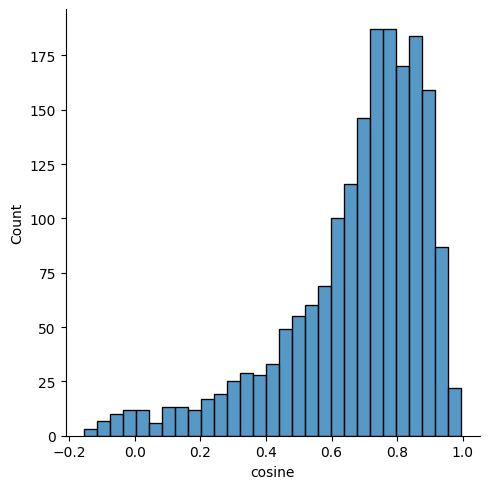

In [45]:
sns.displot(df_gpt4o['cosine'])

### gpt-3.5-turbo

In [146]:
results_gpt35 = df_gpt35.to_dict(orient='records')

similarity_35 = []

for record in tqdm(results_gpt35):
    sim = compute_similarity(record)
    similarity_35.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [147]:
df_gpt35['cosine'] = similarity_35
df_gpt35['cosine'].describe()

count    1830.000000
mean        0.657599
std         0.226062
min        -0.168921
25%         0.546504
50%         0.714783
75%         0.817262
max         1.000000
Name: cosine, dtype: float64

In [149]:
import matplotlib.pyplot as plt

### gpt-4o-mini

In [151]:
def process_record_4o_mini(rec):
    model = 'gpt-4o-mini'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [152]:
process_record_4o_mini(ground_truth[10])

{'answer_llm': "Yes, sessions are recorded, so if you miss one, you won't miss anything. You can catch up by watching the recorded sessions later. Additionally, you have the option to ask questions in advance for office hours, which will also be recorded.",
 'answer_orig': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

In [ ]:
results_gpt4omini = []

In [157]:
for record in tqdm(ground_truth):
    result = process_record_4o_mini(record)
    results_gpt4omini.append(result)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [160]:
df_gpt4o_mini = pd.DataFrame(results_gpt4omini)
df_gpt4o_mini.to_csv('data/results-gpt4o-mini.csv', index=False)

In [161]:
similarity_4o_mini = []

for record in tqdm(results_gpt4omini):
    sim = compute_similarity(record)
    similarity_4o_mini.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [162]:
df_gpt4o_mini['cosine'] = similarity_4o_mini
df_gpt4o_mini['cosine'].describe()

count    1830.000000
mean        0.680332
std         0.215962
min        -0.141910
25%         0.585866
50%         0.733998
75%         0.836750
max         0.982701
Name: cosine, dtype: float64

gpt4o 

```
count    1830.000000
mean        0.679129
std         0.217995
min        -0.153426
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995339
Name: cosine, dtype: float64
```

C:\Users\alexe\AppData\Local\Temp\ipykernel_8108\4043211035.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'], label='4o')
C:\Users\alexe\AppData\Local\Temp\ipykernel_8108\4043211035.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o_mini['cosine'], label='4o-mini'

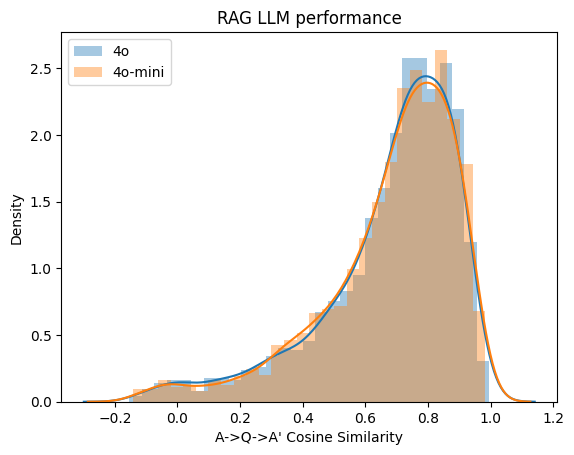

In [250]:
# sns.distplot(df_gpt35['cosine'], label='3.5')

sns.distplot(df_gpt4o['cosine'], label='4o')
sns.distplot(df_gpt4o_mini['cosine'], label='4o-mini')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

## LLM-as-a-Judge

In [62]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [68]:
df_gpt4o_mini = pd.read_csv('results-gpt4o-mini-cosine.csv')

In [69]:
df_sample = df_gpt4o_mini.sample(n=50, random_state=1)

In [70]:
df_sample

,answer_llm,answer_orig,document,question,course,cosine
726,The syntax for using `precision_recall_fscore_...,Scikit-learn offers another way: precision_rec...,403bbdd8,What is the syntax for using precision_recall_...,machine-learning-zoomcamp,0.901076
1662,"To avoid pickle errors when using waitress, yo...",When running a docker container with waitress ...,236864c2,How should I modify my scripts to avoid pickle...,machine-learning-zoomcamp,0.721914
834,The command to launch a container image in int...,Launch the container image in interactive mode...,63a81b57,What command launches a container image in int...,machine-learning-zoomcamp,0.836726
1234,"Yes, you can make a pull request for homework ...",Pytorch is also a deep learning framework that...,c4ff26e5,Can we make a pull request for homework soluti...,machine-learning-zoomcamp,0.549889
1323,The cause of the pip version error in this wee...,When running docker build -t dino-dragon-model...,42c09143,What might be the cause of the pip version err...,machine-learning-zoomcamp,0.309405
1461,"After editing the metrics-server, you should r...",In case the HPA instance does not run correctl...,df023a13,What command do we run after editing the metri...,machine-learning-zoomcamp,0.838569
1529,To check your AWS CLI version for eksctl compa...,Make sure you are on AWS CLI v2 (check with aw...,00882c83,How can I check my AWS CLI version for eksctl ...,machine-learning-zoomcamp,0.641516
698,One main reason for different accuracy values ...,"One main reason behind that, is the way of spl...",25481ce5,What is one main reason for different accuracy...,machine-learning-zoomcamp,0.559826
1289,If you lose the REMOTE_URI variable after the ...,"Solution description\nIn the unit 9.6, Alexey ...",60fa95ed,What should I do if I lose the REMOTE_URI vari...,machine-learning-zoomcamp,0.505633
1751,You can find the script for generating the Kit...,The image dataset for the competition was in a...,20174c95,Where can I find the script for generating the...,machine-learning-zoomcamp,0.642981


In [71]:
samples = df_sample.to_dict(orient='records')

In [72]:
record = samples[0]
record

{'answer_llm': 'The syntax for using `precision_recall_fscore_support` in Python is as follows:\n\n```python\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n```',
 'answer_orig': 'Scikit-learn offers another way: precision_recall_fscore_support\nExample:\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n(Gopakumar Gopinathan)',
 'document': '403bbdd8',
 'question': 'What is the syntax for using precision_recall_fscore_support in Python?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.9010756}

In [73]:
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: Scikit-learn offers another way: precision_recall_fscore_support
Example:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)
(Gopakumar Gopinathan)
Generated Question: What is the syntax for using precision_recall_fscore_support in Python?
Generated Answer: The syntax for using `precision_recall_fscore_support` in Python is as follows:

```python
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_

In [74]:
answer = llm(prompt, model='gpt-4o-mini')

In [75]:
answer

'{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer provides the exact syntax for using `precision_recall_fscore_support` in Python, which directly responds to the question about its syntax. It includes a code example identical to the one in the original answer, making it fully relevant."\n}'

In [76]:
import json

In [84]:
evaluations = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations.append(evaluation)

100%|██████████| 50/50 [01:33<00:00,  1.86s/it]


In [85]:
evaluations

['{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer directly provides the syntax for using `precision_recall_fscore_support`, which is exactly what the original answer discussed. The content matches perfectly, including the code example."\n}',
 '{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer directly addresses the question about modifying scripts to avoid pickle errors when using waitress. It accurately summarizes the solution provided in the original answer, including the key detail of placing the custom column transformer class into a separate module and importing it in both the saving and loading scripts. Thus, it maintains high relevance and fidelity to the original content."\n}',
 '{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer directly provides the command needed to launch a container image in interactive mode, which is the focus of the original answer. It accurately reflects the key information given in the origin

In [86]:
json_evaluations = []

for i, str_eval in enumerate(evaluations):
    json_eval = json.loads(str_eval)
    json_evaluations.append(json_eval)

In [87]:
json_evaluations

[{'Relevance': 'RELEVANT',
  'Explanation': 'The generated answer directly provides the syntax for using `precision_recall_fscore_support`, which is exactly what the original answer discussed. The content matches perfectly, including the code example.'},
 {'Relevance': 'RELEVANT',
  'Explanation': 'The generated answer directly addresses the question about modifying scripts to avoid pickle errors when using waitress. It accurately summarizes the solution provided in the original answer, including the key detail of placing the custom column transformer class into a separate module and importing it in both the saving and loading scripts. Thus, it maintains high relevance and fidelity to the original content.'},
 {'Relevance': 'RELEVANT',
  'Explanation': 'The generated answer directly provides the command needed to launch a container image in interactive mode, which is the focus of the original answer. It accurately reflects the key information given in the original response without any 

In [88]:
df_evaluations = pd.DataFrame(json_evaluations)

In [89]:
df_evaluations

,Relevance,Explanation
0,RELEVANT,The generated answer directly provides the syn...
1,RELEVANT,The generated answer directly addresses the qu...
2,RELEVANT,The generated answer directly provides the com...
3,RELEVANT,The generated answer directly addresses the qu...
4,NON_RELEVANT,The generated answer discusses a pip version e...
5,RELEVANT,The generated answer directly addresses the qu...
6,RELEVANT,The generated answer accurately addresses the ...
7,RELEVANT,The generated answer effectively addresses the...
8,RELEVANT,The generated answer directly addresses the co...
9,RELEVANT,The generated answer directly addresses the qu...


In [90]:
df_evaluations.Relevance.value_counts()

Relevance
RELEVANT           39
PARTLY_RELEVANT     6
NON_RELEVANT        5
Name: count, dtype: int64

In [91]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT'] #.to_dict(orient='records')

,Relevance,Explanation
4,NON_RELEVANT,The generated answer discusses a pip version e...
11,NON_RELEVANT,The generated answer provides steps related to...
27,NON_RELEVANT,The generated answer incorrectly states that t...
41,NON_RELEVANT,The generated answer addresses a completely di...
49,NON_RELEVANT,The generated answer states that there is no m...


In [93]:
samples[4]

{'answer_llm': "The cause of the pip version error in this week's serverless deep learning section could be a version conflict in Scikit-Learn. Specifically, if you are using a different version than what was used during the model training, it can lead to warnings and potential breaking code or invalid results. To resolve this, make sure to use the same version of Scikit-Learn that was used for training the model. For instance, if you trained with version 1.1.1, you should use that same version in your virtual environment.",
 'answer_orig': 'When running docker build -t dino-dragon-model it returns the above error\nThe most common source of this error in this week is because Alex video shows a version of the wheel with python 8, we need to find a wheel with the version that we are working on. In this case python 9. Another common error is to copy the link, this will also produce the same error, we need to download the raw format:\nhttps://github.com/alexeygrigorev/tflite-aws-lambda/raw

In [94]:
prompt = prompt2_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: Do you have a YouTube video covering Evaluation Metrics for Classification?
Generated Answer: Based on the provided context, there is no mention of a YouTube video covering Evaluation Metrics for Classification. The information provided focuses on methods to obtain classification metrics and visualizations using libraries such as scikit-learn and Yellowbrick, but does not reference any video resources.

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a bri

In [95]:
evaluation = llm(prompt, model='gpt-4o-mini')
print(evaluation)

{
  "Relevance": "PARTLY_RELEVANT",
  "Explanation": "The generated answer acknowledges that there is no mention of a YouTube video, which directly addresses the question. However, it provides additional context about classification metrics and relevant libraries, indicating some related information, thus falling into the 'PARTLY_RELEVANT' category."
}


In [96]:
evaluations_2 = []

for record in tqdm(samples):
    prompt = prompt2_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations_2.append(evaluation)

100%|██████████| 50/50 [01:21<00:00,  1.63s/it]


In [97]:
json_evaluations_2 = []

for i, str_eval in enumerate(evaluations_2):
    json_eval = json.loads(str_eval)
    json_evaluations_2.append(json_eval)

In [98]:
df_evaluations_2 = pd.DataFrame(json_evaluations_2)

In [99]:
df_evaluations_2.Relevance.value_counts()

Relevance
RELEVANT           41
PARTLY_RELEVANT     7
NON_RELEVANT        2
Name: count, dtype: int64

In [100]:
df_evaluations_2[df_evaluations_2.Relevance == 'NON_RELEVANT']

,Relevance,Explanation
45,NON_RELEVANT,The generated answer explicitly states that it...
49,NON_RELEVANT,The generated answer does not address the ques...


In [101]:
samples[45]

{'answer_llm': 'The provided context does not include specific commands to start the Docker daemon on Linux. Therefore, I cannot provide an answer based solely on the facts from the context.',
 'answer_orig': 'Working on getting Docker installed - when I try running hello-world I am getting the error.\nDocker: Cannot connect to the docker daemon at unix:///var/run/docker.sock. Is the Docker daemon running ?\nSolution description\nIf you’re getting this error on WSL, re-install your docker: remove the docker installation from WSL and install Docker Desktop on your host machine (Windows).\nOn Linux, start the docker daemon with either of these commands:\nsudo dockerd\nsudo service docker start\nAdded by Ugochukwu Onyebuchi',
 'document': '4b2a3181',
 'question': 'What commands should I use to start the docker daemon on Linux?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.5113021}

## Saving all the data

In [ ]:
# df_gpt4o.to_csv('data/results-gpt4o-cosine.csv', index=False)
# df_gpt35.to_csv('data/results-gpt35-cosine.csv', index=False)
# df_gpt4o_mini.to_csv('data/results-gpt4o-mini-cosine.csv', index=False)

In [103]:
df_evaluations.to_csv('evaluations-aqa.csv', index=False)
df_evaluations_2.to_csv('evaluations-qa.csv', index=False)